In [1]:
from analysis.analysis import *
import matplotlib.pyplot as plt
import os

root = "defaults"
gid = 26
default_LC_gid = 10

Read the raw sim data for a grid ID

In [2]:
data_root = f"/mnt/c/Users/pedro/OneDrive - Johns Hopkins/Documents/Research/hopper/_server/sim_data/{root}"

grid_df = read_fulltake(
    os.path.join(data_root, f"parquets/fulltake_gid{gid}.parquet"), scale_position=True
)

grid_df.rid.unique().size, yaml.safe_load(
    open(os.path.join(data_root, f"configs/grid_id{gid}/cell.yaml"), "rb")
), yaml.safe_load(
    open(os.path.join(data_root, f"configs/grid_id{gid}/simbox.yaml"), "rb")
)

(4800,
 {'N_wetting': 500,
  'R_eq': 3.0,
  'R_init': 2.75,
  'R_ten_factor': 1.5,
  'alpha': 50,
  'eta': 0.5,
  'gamma': 0.8,
  'id': 0,
  'interpolate_cntrs': False,
  'lam': 0.8,
  'mu_mvg': 7.5,
  'nu': 0,
  'perturbation': 0,
  'polarity_mode': 'IM',
  'sigma_mvg': 37.5,
  'tau': 0.5,
  'tau_mvg': 0.0045,
  'tau_ten': 1.0,
  'tau_x': 0.02},
 {'L_box': 50,
  'N': 240000,
  'N_mesh': 200,
  'dt': 0.00075,
  'simbox_view_freq': 500000,
  'stat_collection_freq': 500,
  'substrate': {'buffer': 0, 'kind': 'rectangular', 'sub_sep': 73, 'xi': 0.2}})

Histogram of hopping times _vs._ default limit-cycle cell

In [3]:
try:
    plt.figure(figsize=(3, 2), dpi=100)
    plt.hist(
        np.load(f"../_server/sim_data/{root}/hopping times/fulltake_gid{gid}.npy"),
        density=True,
        bins=40,
        alpha=0.75,
        color="cornflowerblue",
        label=f"Grid {gid}",
    )
    plt.hist(
        np.load(f"../_server/sim_data/{root}/hopping times/fulltake_gid{10}.npy"),
        density=True,
        bins=40,
        alpha=0.75,
        color="salmon",
        label=f"Grid {default_LC_gid}",
    )
    plt.xlabel("Hopping times (hr)")
    plt.legend()
    plt.show()
except FileNotFoundError:
    print("Make sure to first run compute_hopping_times.py")

Make sure to first run compute_hopping_times.py


<Figure size 300x200 with 0 Axes>

Apply a time filter (min) to raw data and compute $x, v, a$
- Sims collect at a rate of 3 min

In [4]:
grid_df_samples = apply_time_filter(grid_df, dt=3, base_rate=3)

nbins = 32
xva_df = get_xva_df(
    grid_df_samples,
    nbins,
    yfile=os.path.join(data_root, f"configs/grid_id{gid}/simbox.yaml"),
)

Plot of $F(x, v)$ with streamlines and $\sigma(x, v)$

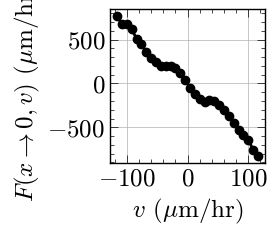

In [5]:
def dynamicsplot(ax, F, bounds, labels, end_pts, delta=1, **kwargs):
    X, Y, init_pts = full_lattice(F, *bounds)

    # raw
    v, f = evaluate_F_v_x0(Y, F, bounds[-1], delta=delta)
    lim = np.fabs([v.min(), v.max()]).min()
    v_interp = np.linspace(-lim, lim, 30)
    f_interp = np.interp(v_interp, v, f)

    kwargs = {"lw": 2, "color": "black"} | kwargs
    ax.plot(v_interp, f_interp, "-o", **kwargs)
    ax.grid(which="major")
    ax.set_xlabel(r"$v$ ($\mu$m/hr)")
    ax.set_ylabel(r"$F(x\rightarrow 0, v)$ ($\mu$m/hr$^2$)")


bounds, F, sigma = compute_F_sigma(xva_df, nbins=nbins, min_pts=2)
xmin, xmax = bounds["x"]
vmin, vmax = bounds["v"]
bounds = (xmin, xmax, vmin, vmax, nbins)

dynamicsplot(plt.gca(), F, bounds, "", "")

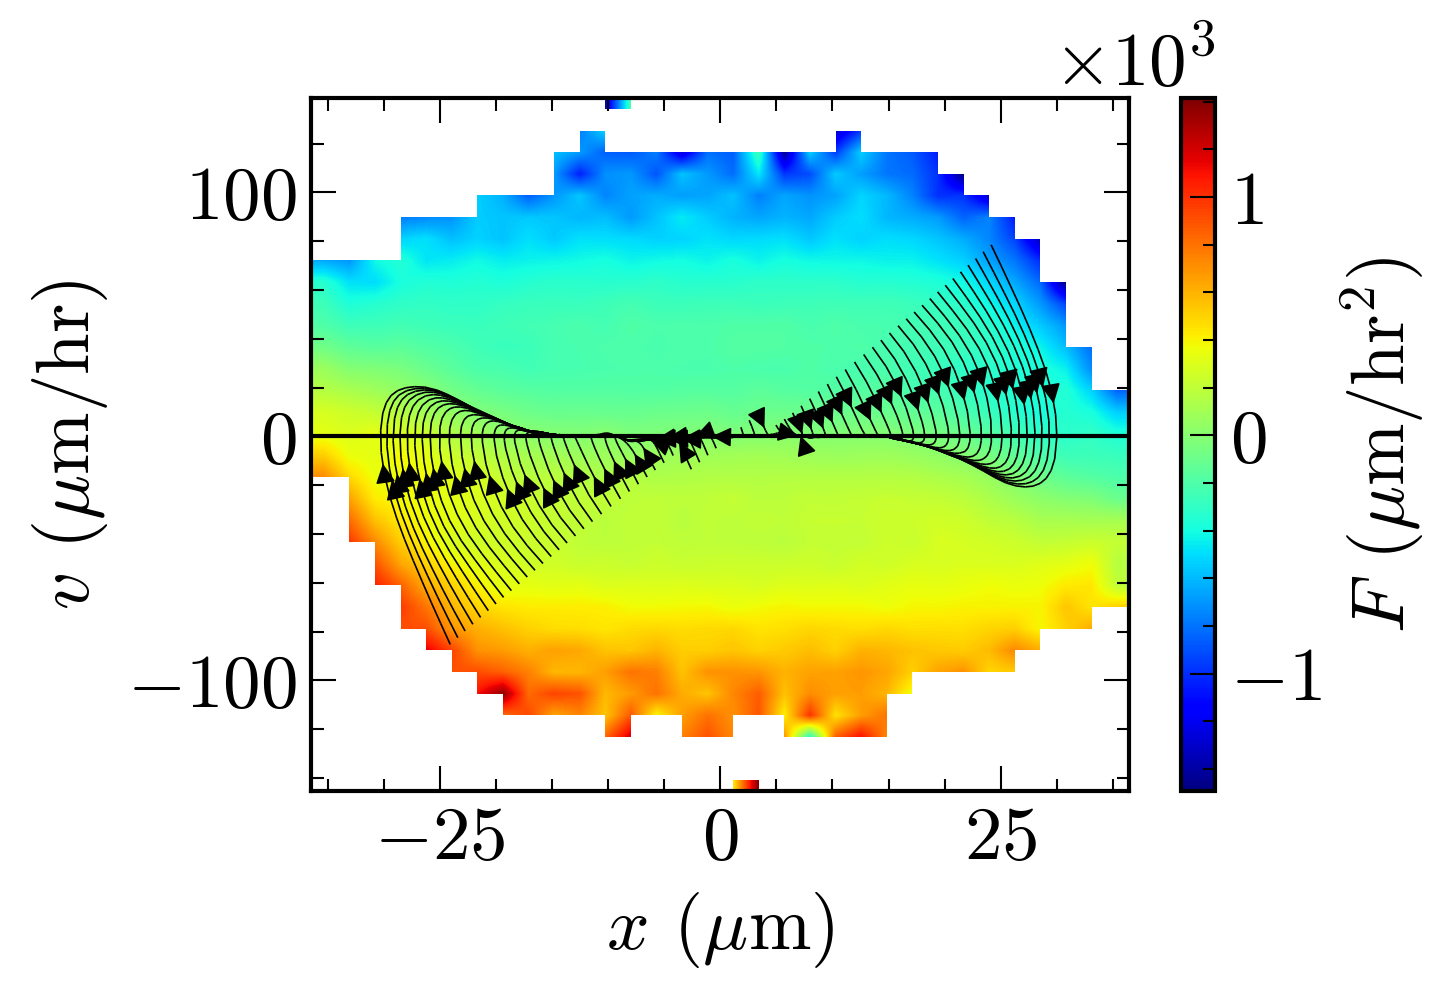

In [6]:
bounds, F, sigma = compute_F_sigma(xva_df, nbins=nbins, min_pts=2)

xmin, xmax = bounds["x"]
vmin, vmax = bounds["v"]
x_c = (xmax + xmin) / 2
xmin, xmax = np.array([xmin, xmax]) - x_c  # center along x
bounds_tup = (xmin, xmax, vmin, vmax, nbins)

plot_title = make_title(xva_df)
title = {"label": plot_title, "fontsize": 20}

# init_pts[:, 1] += 20
fig, ax = plt.subplots(1, 2, figsize=(11, 3), dpi=300)

X, Y, init_pts = full_lattice(F, xmin, xmax, vmin, vmax, nbins)
init_pts = linear_lattice(xmin, xmax, vmin, vmax, n_pts=100, s=1)

ax[0].set_title(**title)
ax[0].axhline(y=0, lw=1, color="black", zorder=2)

F_streamplot(
    F,
    bounds_tup,
    stream_init_pts=init_pts,
    imshow_kwargs={"interpolation": "bilinear", "origin": "lower", "cmap": "jet"},
    streamplot_kwargs={
        "integration_direction": "forward",
        "color": "black",
        "broken_streamlines": False,
        "density": 1,
        "linewidth": 0.4,
    },
    do_try=True,
    vector_field=False,
    ax=ax[0],
)

if gid == -1:
    import pickle

    data = pickle.load(open(f"maps/map_{gid}.pkl", "rb"))
    end_pts = data["end_pts"]
    ax[0].scatter(
        end_pts[:, 0] - x_c,
        end_pts[:, 1],
        s=50,
        color="red",
        marker="x",
        zorder=10,
    )

ax[1].remove()
ax[0].set_title("")

plt.subplots_adjust(wspace=0.5)
plt.show()

(<matplotlib.collections.LineCollection at 0x7f2387d0df00>, 1709108065.0)

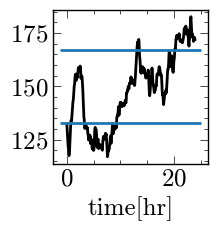

In [7]:
_df = grid_df[grid_df.rid == np.random.randint(grid_df.rid.unique().size)]
_df.plot(x="time[hr]", y="x", color="black", legend=False)
plt.gca().hlines([133, 167], *plt.gca().get_xlim()), _df.iloc[0].seed

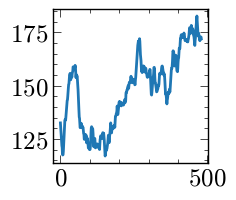

In [8]:
plt.plot(_df.x)

Phase separation for bistable cases

In [9]:
from importlib import reload
from analysis import analysis

reload(analysis)
from analysis.analysis import lattice_to_image

In [10]:
X, Y, init_pts = full_lattice(F, xmin, xmax, vmin, vmax, nbins)

labels, end_pts = get_labels(init_pts, X, Y, F, x_L=135, x_R=165)
end_pts = np.array(end_pts)
set(labels)

{'gainsboro', 'salmon'}

In [11]:
# labels_ = np.where(np.array(labels) == "wheat", "gainsboro", labels)
img = lattice_to_image(init_pts, labels, bounds_tup)


arr = np.where(img == 1, 0, 1)
X = get_separatrices(img, levels=[1.5], origin="lower", extent=[xmin, xmax, vmin, vmax])

arr = np.where(img == 1, 1, 0)
X2 = get_separatrices(
    arr, levels=[0.5], origin="lower", extent=[xmin, xmax, vmin, vmax]
)

# plot
plt.figure(figsize=(3, 3), dpi=300)
plt.vlines(
    x=135, ymin=vmin, ymax=vmax, linewidth=1, colors=["black"], linestyles=["dashed"]
)
plt.vlines(
    x=165, ymin=vmin, ymax=vmax, linewidth=1, colors=["black"], linestyles=["dashed"]
)

plt.scatter(init_pts[:, 0], init_pts[:, 1], color=labels, s=5)
# plt.plot(X[:, 0], X[:, 1], lw=1.5, color="black")
plt.plot(X2[:, 0], X2[:, 1], lw=1.5, color="black")

# plt.scatter(end_pts[:, 0], end_pts[:, 1], marker="*", s=10, color="black")
plt.xlabel(r"$x$ ($\mu$m)")
plt.ylabel(r"$v$ ($\mu$m/hr)")

xlim = plt.xlim()
ylim = plt.ylim()

# Add fancy legends
import matplotlib.patches as mpatches

legend_dict = {
    "salmon": mpatches.Patch(color="salmon", label="Left"),
    "cornflowerblue": mpatches.Patch(color="cornflowerblue", label="Right"),
    "wheat": mpatches.Patch(color="wheat", label="Middle"),
    "red": mpatches.Patch(color="red", label="Unkn"),
}
legend = []
for c in np.unique(labels):
    legend.append(legend_dict[c]) if c != "gainsboro" else None
plt.legend(handles=legend, bbox_to_anchor=(1.01, 1))
plt.show()

ValueError: need at least one array to concatenate

In [ ]:
sys.exit(01)

In [ ]:
def process_gid(gid):
    import pickle

    data = pickle.load(open(f"maps/map_{gid}.pkl", "rb"))
    if len(data["labels"]) > 0:
        return data["F"], data["bounds"], data["labels"], data["end_pts"]
    return data["F"], data["bounds"]

In [ ]:
F, bounds, labels, end_pts = process_gid(110)
xmin, xmax, vmin, vmax, nbins = bounds

np.vstack(np.meshgrid(np.arange(nbins), np.arange(nbins)))

In [ ]:
dx = (xmax - xmin) / nbins
dv = (vmax - vmin) / nbins
X, Y = np.meshgrid(np.arange(nbins), np.arange(nbins))
X = X * dx + xmin + dx / 2
Y = Y * dv + vmin + dv / 2
init_pts = np.hstack([X.reshape(-1, 1), Y.reshape(-1, 1)])

labels, end_pts = get_labels(init_pts, X, Y, F, x_L=135, x_R=165)

In [ ]:
img = lattice_to_image(init_pts, labels, bounds)

arr = np.where(img == 1, 0, 1)
X = get_separatrices(arr, levels=[0.5], origin="lower", extent=[xmin, xmax, vmin, vmax])

arr = np.where(img == 1, 1, 0)
X2 = get_separatrices(
    arr, levels=[0.01], origin="lower", extent=[xmin, xmax, vmin, vmax]
)

# plot
plt.figure(figsize=(3, 3), dpi=300)
plt.vlines(
    x=135, ymin=vmin, ymax=vmax, linewidth=1, colors=["black"], linestyles=["dashed"]
)
plt.vlines(
    x=165, ymin=vmin, ymax=vmax, linewidth=1, colors=["black"], linestyles=["dashed"]
)

plt.scatter(init_pts[:, 0], init_pts[:, 1], color=labels, s=5)
# plt.plot(X[:, 0], X[:, 1], lw=2, color="black")
plt.plot(X2[:, 0], X2[:, 1], lw=2, color="black")

# plt.scatter(end_pts[:, 0], end_pts[:, 1], marker="*", s=10, color="black")
plt.xlabel(r"$x$ ($\mu$m)")
plt.ylabel(r"$v$ ($\mu$m/hr)")

xlim = plt.xlim()
ylim = plt.ylim()

# Add fancy legends
import matplotlib.patches as mpatches

legend_dict = {
    "salmon": mpatches.Patch(color="salmon", label="Left"),
    "cornflowerblue": mpatches.Patch(color="cornflowerblue", label="Right"),
    "wheat": mpatches.Patch(color="wheat", label="Middle"),
    "red": mpatches.Patch(color="red", label="Unkn"),
}
legend = []
for c in np.unique(labels):
    legend.append(legend_dict[c]) if c != "gainsboro" else None
plt.legend(handles=legend, bbox_to_anchor=(1.01, 1))
# plt.xlim((135, 165))
# plt.ylim((-20, 20))
plt.show()

In [ ]:
class IntegrateF:
    def __init__(self, X, V, F):
        self.X = X
        self.V = V
        self.F = F

    def integrate(self, x0, v0, T, seed=0):
        x = [x0]
        v = [v0]
        delta_t = 0.00075 * 8 / 60  # hr
        delta_t = 0.01

        rng = np.random.default_rng(seed=seed)

        for t in range(1, T):
            if np.isnan([x[t - 1], v[t - 1]]).any() or not (
                self.X.min() <= x[t - 1] <= self.X.max()
                and self.V.min() <= v[t - 1] <= self.V.max()
            ):
                break

            i, j = self.get_bin_index(x[t - 1], v[t - 1], self.X, self.V)
            _x = x[t - 1] + v[t - 1] * delta_t
            _v = v[t - 1] + self.F[i, j] * delta_t
            x.append(_x)
            v.append(_v)
        return np.vstack([x, v]).T

    @staticmethod
    def get_bin_index(x, v, X, V):
        return np.searchsorted(V, v, side="left"), np.searchsorted(X, x, side="left")


F, bounds, labels, end_pts = process_gid(10)
xmin, xmax, vmin, vmax, nbins = bounds
X, V, init_pts = full_lattice(F, *bounds)
X = X[0]
V = V[:, 0]

integrator = IntegrateF(X, V, F)
k = 30
x_traj = integrator.integrate(*init_pts[k], T=500)

plt.imshow(F, origin="lower", extent=[xmin, xmax, vmin, vmax])
plt.scatter(*init_pts[k], s=40, color="red")
plt.scatter(x_traj[:, 0], x_traj[:, 1], s=10, color="cyan")
plt.axis("auto")

In [ ]:
import sys

sys.exit(1)

# Plots for Paper

In [ ]:
from substrate.substrates import Substrate
import matplotlib.pyplot as plt

sub_gen = Substrate(200, 50, xi=0.2)
rect = sub_gen.rectangular()

ext = 0
l = 38 + ext
d = 73 + ext
ts = sub_gen.two_state_sub(square_width=l, bridge_width=17, delta_centers=d)

# fig, ax = plt.subplot_mosaic([[0, 1], [2, 2]], figsize=(3, 2), dpi=300)
fig, ax = plt.subplots(1, 2, figsize=(4, 2), dpi=300)

for a, im, title in zip(ax, [ts, rect], ["Two-state", "Rectangular"]):
    alpha = 0 if title == "" else 1
    a.imshow(im, extent=[0, 50 * 6, 0, 50 * 6], cmap="Greys_r", alpha=alpha)
    # a.contour(im, levels=[0.5], linewidths=[1], colors=["cornflowerblue"], extent=[0, 50 * 6, 0, 50 * 6])
    a.set_xlim([80, 220])
    a.set_ylim([100, 200])
    a.get_xaxis().set_visible(False)
    a.get_yaxis().set_visible(False)
    a.set_frame_on(False)
    a.set_title(title, fontsize=10)

    if title == "Two-state":
        a.arrow(
            100,
            110,
            10,
            0,
            width=0.001,
            head_width=3,
            head_length=2,
            color="black",
        )
        a.arrow(
            100,
            110,
            0,
            10,
            width=0.001,
            head_width=3,
            head_length=2,
            color="black",
        )
        a.text(115, 110, r"$x$", {"fontsize": 8})
        a.text(105, 120, r"$y$", {"fontsize": 8})


from matplotlib_scalebar.scalebar import ScaleBar

scalebar = ScaleBar(
    dx=1,
    units="um",
    location="center left",
    pad=-1.25,
    border_pad=0,
    box_alpha=0,
    font_properties={"size": 8},
)
a.add_artist(scalebar)

plt.savefig("paper_plots/geometries.jpg")
plt.show()

In [ ]:
from polarity.mvgaussian import MVGaussian
from cell.cell import Cell
from box.sim_box import SimulationBox
import matplotlib.pyplot as plt
import numpy as np

extent = [0, 10, 0, 10]
kwargs = {"origin": "lower"}
cell = Cell(
    "../configs/IM/grid_id10/cell.yaml",
    SimulationBox("../configs/IM/grid_id10/simbox.yaml"),
    seed=0,
)

c = cell.contour[0][69][::-1]
patch = cell.mvg_gen.pdf(c, np.array([[20, 0], [0, 20]]))
patch = patch.reshape(cell.phi.shape)
patch *= cell.phi
patch *= cell.phi**2 >= 0.25
patch = np.where(patch == 0, np.nan, patch)

plt.figure(dpi=300)
plt.contour(cell.phi, levels=[0.5], colors=["black"], **kwargs)
plt.imshow(patch, cmap="Purples", **kwargs)
plt.scatter(*c, color="plum", zorder=2, s=100)
plt.xlim([113 * 200 / 200, 136.1 * 200 / 200])
plt.ylim([88 * 200 / 200, 112 * 200 / 200])
plt.axis("off")
plt.tight_layout()